Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [1]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.3/992.3 KB 3.5 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import requests
import pandas as pd
import os, time, warnings
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
import logging
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, 
    LSTM, 
    InputLayer, 
    Dropout, 
    Conv1D, 
    Conv2D, 
    Flatten,
    Reshape,
    MaxPooling1D, 
    MaxPooling2D, 
    BatchNormalization, 
    TimeDistributed)

from tensorflow.keras.optimizers import Adam

# visualize model architecture
import visualkeras
from PIL import ImageFont
from tensorflow.keras.utils import plot_model

warnings.filterwarnings("ignore")

In [3]:
log_cols = ["model", "accuracy", "train_time (s)", "pred_time (s)"]
log = pd.DataFrame(columns=log_cols)

In [4]:
API_KEY = 'ei_03511444ca86ca42d62279d7875a4555bfc4c5d5b64b128082382df366cef843'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/103981/training/87/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/103981/training/87/y')

Store the data in a temporary file, and load it back through Numpy.

In [5]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)

In [6]:
# load numpy
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

Define our labels and split the data up in a test and training set:

In [7]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "danger_alarm", "fire_alarm", "gas_alarm", "non_alarm", "tsunami_alarm" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


In [8]:
X.shape

(3000, 2440)

In [9]:
validation_dataset1 = validation_dataset
train_dataset1 = train_dataset

In [10]:
train_dataset

<TensorSliceDataset shapes: ((2440,), (5,)), types: (tf.float32, tf.float32)>

## Train With Conv 1D:

In [11]:
# model architecture
CNN1D_model = Sequential()
CNN1D_model.add(Reshape((int(input_length / 40), 40), input_shape=(input_length, )))
CNN1D_model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
CNN1D_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
CNN1D_model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
CNN1D_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
CNN1D_model.add(Flatten())
CNN1D_model.add(Dropout(0.5))
CNN1D_model.add(Dense(64, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
CNN1D_model.add(Dropout(0.5))
CNN1D_model.add(Dense(classes, activation='softmax', name='y_pred'))

CNN1D_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 61, 40)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 61, 16)            1936      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 31, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 31, 32)            1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

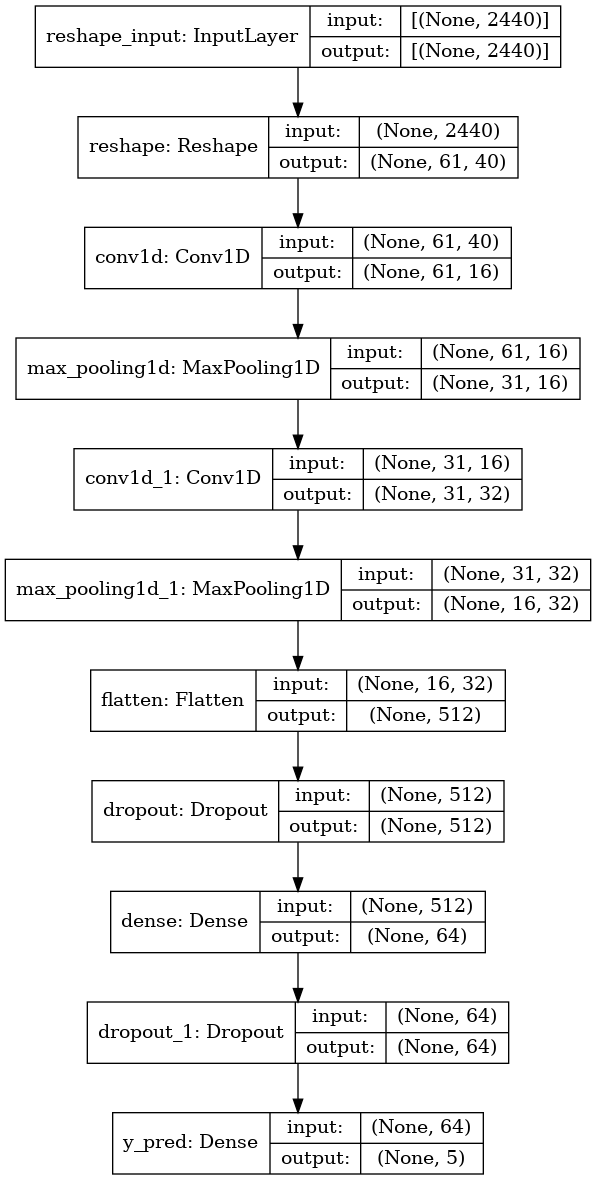

In [15]:
#plot model deep learning
plot_model(CNN1D_model, to_file="model-conv1D-architecture.png", show_shapes=True)

In [16]:
# this controls the learning rate
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
EPOCHS = 100
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset1 = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset1 = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

In [17]:
from datetime import datetime

# time calculation
start = datetime.now()
t0 = time.time()

# train the neural network
CNN1D_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history_CNN1D = CNN1D_model.fit(train_dataset1, epochs=EPOCHS, validation_data=validation_dataset1, 
                                verbose=2, callbacks=callbacks)

train_hist_m1 = pd.DataFrame(history_CNN1D.history)

train_m1 = round(time.time() - t0, 3)
duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/100
75/75 - 2s - loss: 1.1028 - accuracy: 0.5800 - val_loss: 0.6023 - val_accuracy: 0.8100
Epoch 2/100
75/75 - 0s - loss: 0.5243 - accuracy: 0.8329 - val_loss: 0.4752 - val_accuracy: 0.8517
Epoch 3/100
75/75 - 0s - loss: 0.4268 - accuracy: 0.8617 - val_loss: 0.4547 - val_accuracy: 0.8733
Epoch 4/100
75/75 - 0s - loss: 0.3585 - accuracy: 0.8871 - val_loss: 0.2925 - val_accuracy: 0.8950
Epoch 5/100
75/75 - 0s - loss: 0.3163 - accuracy: 0.8992 - val_loss: 0.3376 - val_accuracy: 0.8767
Epoch 6/100
75/75 - 0s - loss: 0.3028 - accuracy: 0.9067 - val_loss: 0.3253 - val_accuracy: 0.8750
Epoch 7/100
75/75 - 0s - loss: 0.2635 - accuracy: 0.9212 - val_loss: 0.3275 - val_accuracy: 0.8967
Epoch 8/100
75/75 - 0s - loss: 0.2477 - accuracy: 0.9150 - val_loss: 0.2039 - val_accuracy: 0.9250
Epoch 9/100
75/75 - 0s - loss: 0.2387 - accuracy: 0.9271 - val_loss: 0.2031 - val_accuracy: 0.9367
Epoch 10/100
75/75 - 0s - loss: 0.2330 - accuracy: 0.9192 - val_loss: 0.1832 - val_accuracy: 0.9367
Epoch 11/

In [18]:
# save Model
CNN1D_model.save("CNN1D_model.h5")
print("CNN1D Model Saved")

CNN1D Model Saved


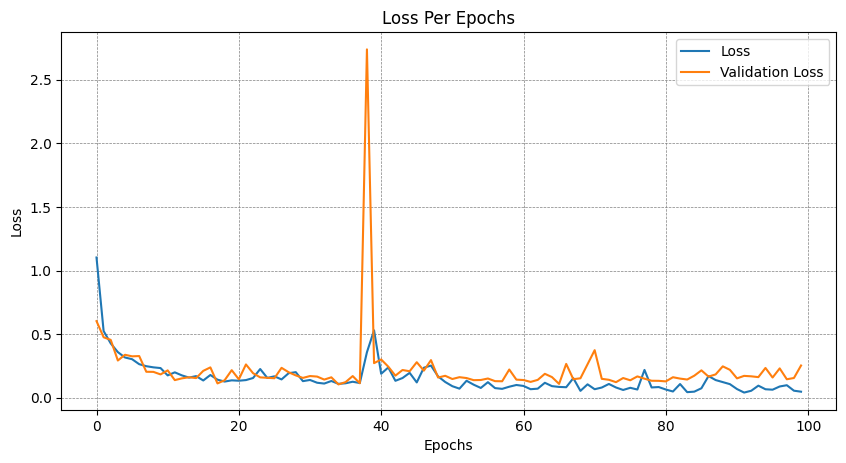

In [19]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m1[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

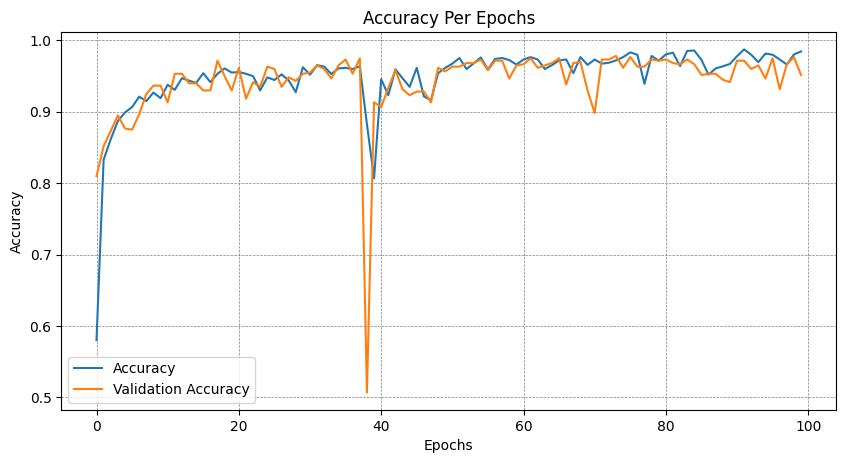

In [20]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m1[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

In [21]:
acc_m1 = CNN1D_model.evaluate(X_test, Y_test, verbose=0)
t0 = time.time()
y_pred_m1 = CNN1D_model.predict(X_test, verbose=0)
pred_m1 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["CNN1", acc_m1[1] * 100, train_m1, pred_m1]], columns=log_cols
)
log = log.append(log_entry)

In [22]:
log

,model,accuracy,train_time (s),pred_time (s)
0,CNN1,95.166665,54.509,0.248


In [23]:
# train Accuracy and Loss
train_loss, train_acc = CNN1D_model.evaluate(X_train, Y_train, verbose=0)
print("train loss: {0:.6f}, train accuracy: {1:.6f}".format(train_loss, train_acc))

# Val Accuracy and Loss
val_loss, val_acc = CNN1D_model.evaluate(X_test, Y_test, verbose=0)
print("val loss: {0:.6f}, val accuracy: {1:.6f}".format(val_loss, val_acc))

train loss: 0.068459, train accuracy: 0.977500
val loss: 0.253210, val accuracy: 0.951667


In [24]:
# Extract samples and labels from validation set (which is batched)
X_val = np.concatenate([x for x, _ in validation_dataset1], axis=0)
y_val = np.concatenate([y for _, y in validation_dataset1], axis=0)

# Run inference on validation set
y_pred = np.argmax(CNN1D_model.predict(X_val), axis=1)

# Convert one-hot encoding to label encoding for ground-truth labels
y_true = np.argmax(y_val, axis=1)

def acc(y_true, y_pred):
    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).mean()

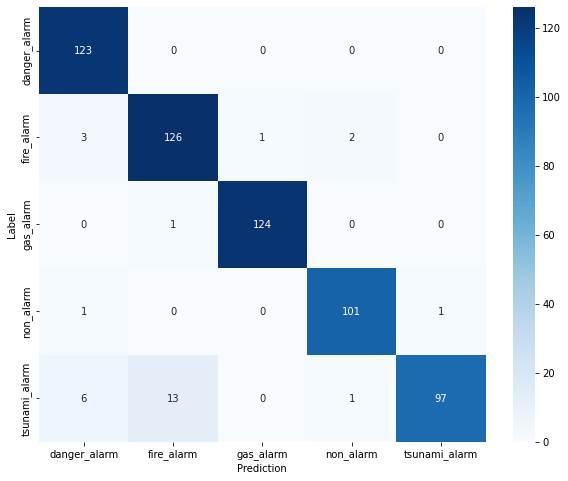

In [25]:
import seaborn as sns

# Labels from project
labels = ["danger_alarm", "fire_alarm", "gas_alarm", "non_alarm", "tsunami_alarm"]

# Show confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g', cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [26]:
from sklearn import metrics
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       123
           1       0.90      0.95      0.93       132
           2       0.99      0.99      0.99       125
           3       0.97      0.98      0.98       103
           4       0.99      0.83      0.90       117

    accuracy                           0.95       600
   macro avg       0.96      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



## Train Using Conv2D

In [27]:
train_dataset

<TensorSliceDataset shapes: ((2440,), (5,)), types: (tf.float32, tf.float32)>

In [28]:
# model architecture
# model architecture
CNN2D_model = Sequential()
channels = 1
columns = 40
rows = int(input_length / (columns * channels))
CNN2D_model.add(Reshape((rows, columns, channels), input_shape=(input_length, )))
CNN2D_model.add(Conv2D(8, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
CNN2D_model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
CNN2D_model.add(Conv2D(16, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
CNN2D_model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
CNN2D_model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
CNN2D_model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
CNN2D_model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
CNN2D_model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
CNN2D_model.add(Flatten())
CNN2D_model.add(Dropout(0.5))
CNN2D_model.add(Dense(64, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
CNN2D_model.add(Dropout(0.5))
CNN2D_model.add(Dense(classes, activation='softmax', name='y_pred'))

CNN2D_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 61, 40, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 61, 40, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 20, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 20, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 10, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 10, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 5, 32)         

In [29]:
# this controls the learning rate
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
EPOCHS = 100
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

In [30]:
validation_dataset

<BatchDataset shapes: ((None, 2440), (None, 5)), types: (tf.float32, tf.float32)>

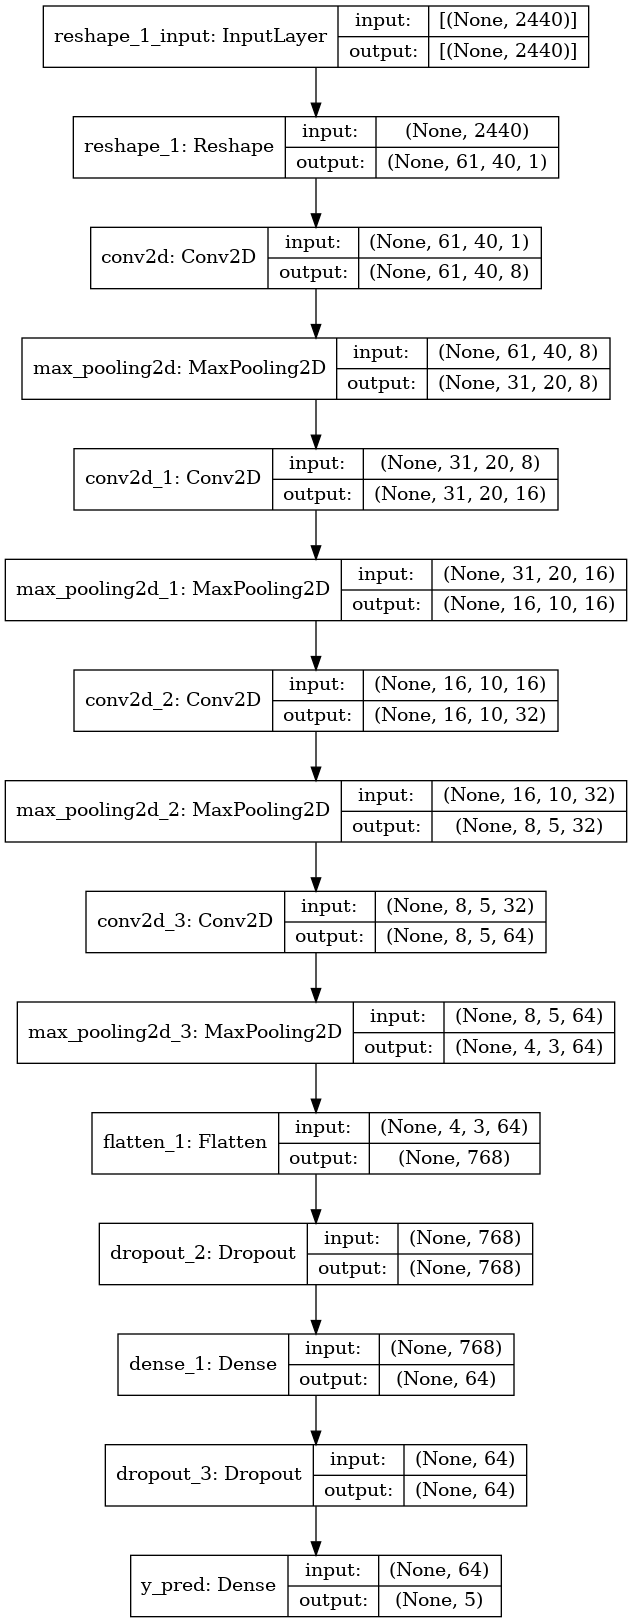

In [31]:
#plot model deep learning
plot_model(CNN2D_model, to_file="model-conv2D-architecture.png", show_shapes=True)

In [32]:
from datetime import datetime 
start = datetime.now()
t0 = time.time()

# train the neural network
CNN2D_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history_CNN2D = CNN2D_model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, verbose=2, callbacks=callbacks)
# Use this flag to disable per-channel quantization for a model.
# This can reduce RAM usage for convolutional models, but may have
# an impact on accuracy.
disable_per_channel_quantization = False

train_hist_m2 = pd.DataFrame(history_CNN2D.history)
train_m2 = round(time.time() - t0, 3)
duration = datetime.now() - start

print("Training completed in time: ", duration)


Epoch 1/100
75/75 - 2s - loss: 0.9289 - accuracy: 0.6233 - val_loss: 0.3962 - val_accuracy: 0.8783
Epoch 2/100
75/75 - 1s - loss: 0.3054 - accuracy: 0.8971 - val_loss: 0.1890 - val_accuracy: 0.9300
Epoch 3/100
75/75 - 1s - loss: 0.1769 - accuracy: 0.9379 - val_loss: 0.1526 - val_accuracy: 0.9583
Epoch 4/100
75/75 - 1s - loss: 0.1180 - accuracy: 0.9608 - val_loss: 0.1748 - val_accuracy: 0.9550
Epoch 5/100
75/75 - 2s - loss: 0.0975 - accuracy: 0.9683 - val_loss: 0.1042 - val_accuracy: 0.9733
Epoch 6/100
75/75 - 1s - loss: 0.0615 - accuracy: 0.9796 - val_loss: 0.0889 - val_accuracy: 0.9750
Epoch 7/100
75/75 - 1s - loss: 0.0580 - accuracy: 0.9837 - val_loss: 0.1109 - val_accuracy: 0.9750
Epoch 8/100
75/75 - 1s - loss: 0.0925 - accuracy: 0.9754 - val_loss: 0.1155 - val_accuracy: 0.9750
Epoch 9/100
75/75 - 1s - loss: 0.0614 - accuracy: 0.9837 - val_loss: 0.2125 - val_accuracy: 0.9683
Epoch 10/100
75/75 - 1s - loss: 0.0803 - accuracy: 0.9762 - val_loss: 0.1554 - val_accuracy: 0.9683
Epoch 11/

In [33]:
# save Model
CNN2D_model.save("model/CNN2D_model.h5")
print("CNN2D Model Saved")

CNN2D Model Saved


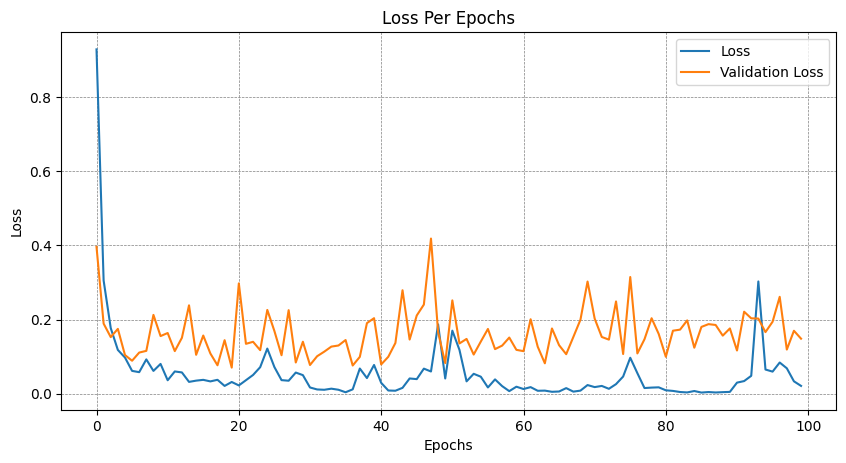

In [34]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m2[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

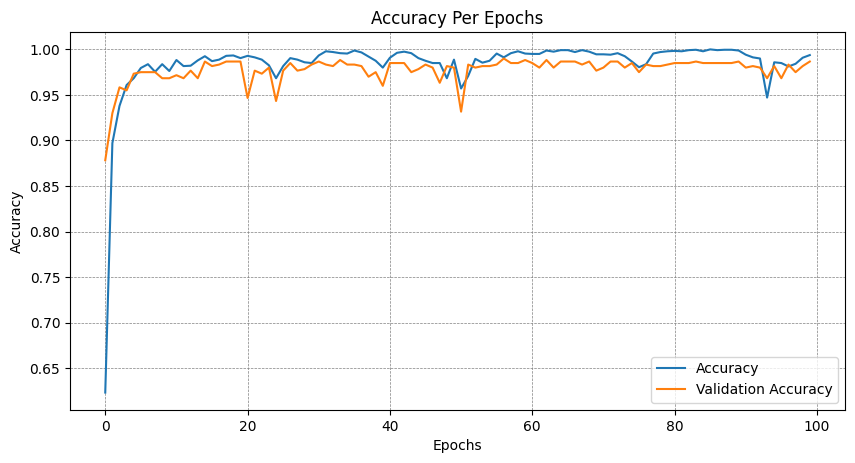

In [35]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m2[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

In [36]:
acc_m2 = CNN2D_model.evaluate(X_test, Y_test, verbose=0)
t0 = time.time()
y_pred_m2 = CNN2D_model.predict(X_test, verbose=0)
pred_m2 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["CNN2D", acc_m2[1] * 100, train_m2, pred_m2]], columns=log_cols
)
log = log.append(log_entry)

In [37]:
log

,model,accuracy,train_time (s),pred_time (s)
0,CNN1,95.166665,54.509,0.248
0,CNN2D,98.666668,120.522,0.250


In [38]:
# train Accuracy and Loss
train_loss, train_acc = CNN1D_model.evaluate(X_train, Y_train, verbose=0)
print("train loss: {0:.6f}, train accuracy: {1:.6f}".format(train_loss, train_acc))

# Val Accuracy and Loss
val_loss, val_acc = CNN1D_model.evaluate(X_test, Y_test, verbose=0)
print("val loss: {0:.6f}, val accuracy: {1:.6f}".format(val_loss, val_acc))

train loss: 0.068459, train accuracy: 0.977500
val loss: 0.253210, val accuracy: 0.951667


In [39]:
# Extract samples and labels from validation set (which is batched)
X_val = np.concatenate([x for x, _ in validation_dataset], axis=0)
y_val = np.concatenate([y for _, y in validation_dataset], axis=0)

# Run inference on validation set
y_pred = np.argmax(CNN1D_model.predict(X_val), axis=1)

# Convert one-hot encoding to label encoding for ground-truth labels
y_true = np.argmax(y_val, axis=1)

def acc(y_true, y_pred):
    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).mean()

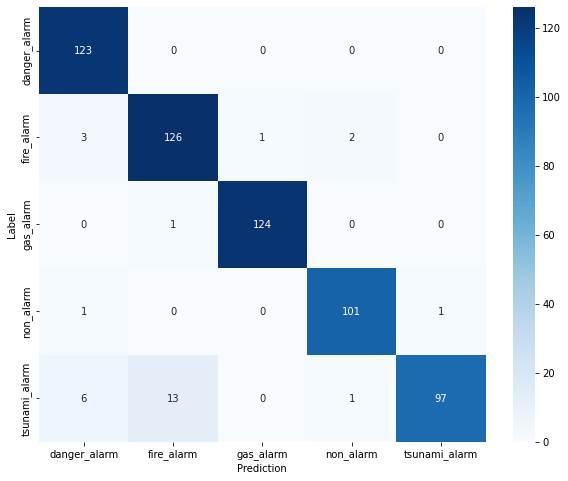

In [40]:
import seaborn as sns

# Labels from project
labels = ["danger_alarm", "fire_alarm", "gas_alarm", "non_alarm", "tsunami_alarm"]

# Show confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g', cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [41]:
from sklearn import metrics
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       123
           1       0.90      0.95      0.93       132
           2       0.99      0.99      0.99       125
           3       0.97      0.98      0.98       103
           4       0.99      0.83      0.90       117

    accuracy                           0.95       600
   macro avg       0.96      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



## Train Using RNN-LSTM

In [42]:
LSTM_model = Sequential([
    Reshape((int(input_length / 40), 40), input_shape=(input_length, )),
    LSTM(128, return_sequences=True, input_shape=(2440, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(classes, activation='softmax')
])
# this controls the learning rate
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)

LSTM_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
LSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 61, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 61, 128)           86528     
_________________________________________________________________
dropout_4 (Dropout)          (None, 61, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)               

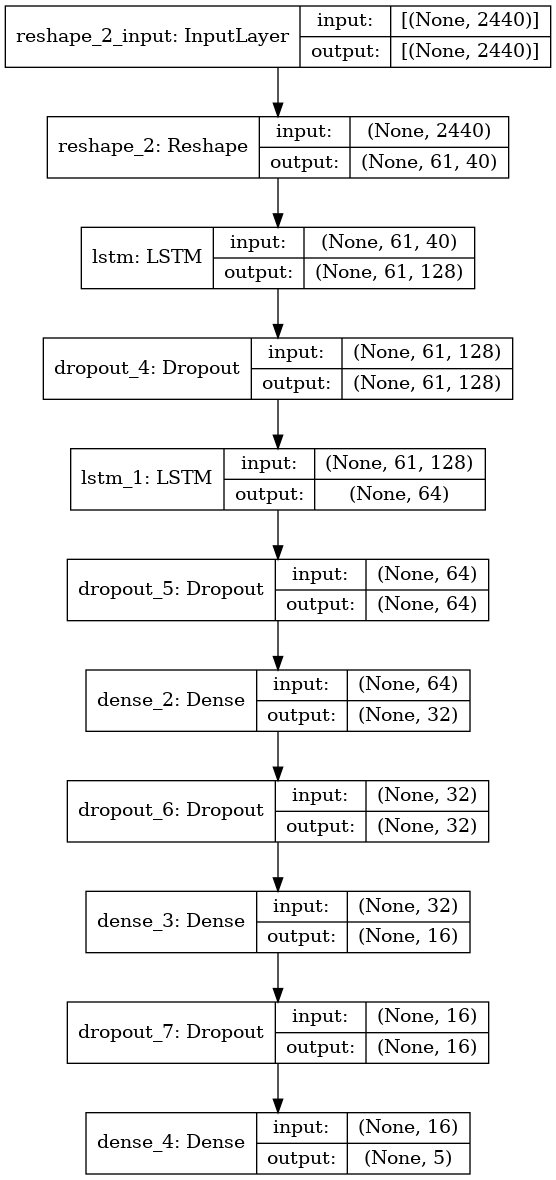

In [43]:
#plot model deep learning
plot_model(LSTM_model, to_file="model-LSTM-architecture.png", show_shapes=True)

In [44]:
from datetime import datetime
t0 = time.time() 
start = datetime.now()
# Train the model
# history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)
history_RNN = LSTM_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=100)
#history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, verbose=2, callbacks=callbacks)

duration = datetime.now() - start
train_hist_m3 = pd.DataFrame(history_RNN.history)
train_m3 = round(time.time() - t0, 3)
print("Training completed in time: ", duration)

Epoch 1/100
75/75 [==============================] - 13s 123ms/step - loss: 1.4417 - accuracy: 0.3146 - val_loss: 1.3188 - val_accuracy: 0.3583
Epoch 2/100
75/75 [==============================] - 9s 119ms/step - loss: 1.2828 - accuracy: 0.4317 - val_loss: 1.0906 - val_accuracy: 0.4883
Epoch 3/100
75/75 [==============================] - 8s 110ms/step - loss: 1.2555 - accuracy: 0.4613 - val_loss: 1.4754 - val_accuracy: 0.3667
Epoch 4/100
75/75 [==============================] - 8s 110ms/step - loss: 1.2096 - accuracy: 0.4771 - val_loss: 1.0420 - val_accuracy: 0.5133
Epoch 5/100
75/75 [==============================] - 8s 113ms/step - loss: 0.9755 - accuracy: 0.5554 - val_loss: 0.8666 - val_accuracy: 0.5767
Epoch 6/100
75/75 [==============================] - 9s 116ms/step - loss: 0.8829 - accuracy: 0.6208 - val_loss: 0.8014 - val_accuracy: 0.6217
Epoch 7/100
75/75 [==============================] - 8s 110ms/step - loss: 0.8365 - accuracy: 0.6463 - val_loss: 0.7135 - val_accuracy: 0.708

In [ ]:
LSTM_model.save("model/RNN_model2.h5")
print("RNN-LSTM Model Saved")

In [57]:
acc_m3 = LSTM_model.evaluate(X_test, Y_test, verbose=0)
t0 = time.time()
y_pred_m3 = LSTM_model.predict(X_test, verbose=0)
pred_m3 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["LSTM", acc_m3[1] * 100, train_m3, pred_m3]], columns=log_cols
)
log = log.append(log_entry)


In [47]:
log

,model,accuracy,train_time (s),pred_time (s)
0,CNN1,95.166665,54.509,0.248
0,CNN2D,98.666668,120.522,0.250
0,LSTM,88.833332,861.323,1.686


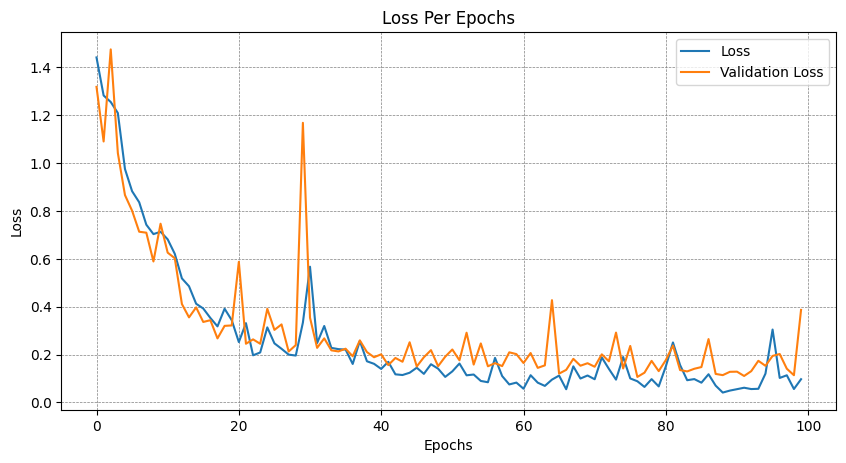

In [48]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m3[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

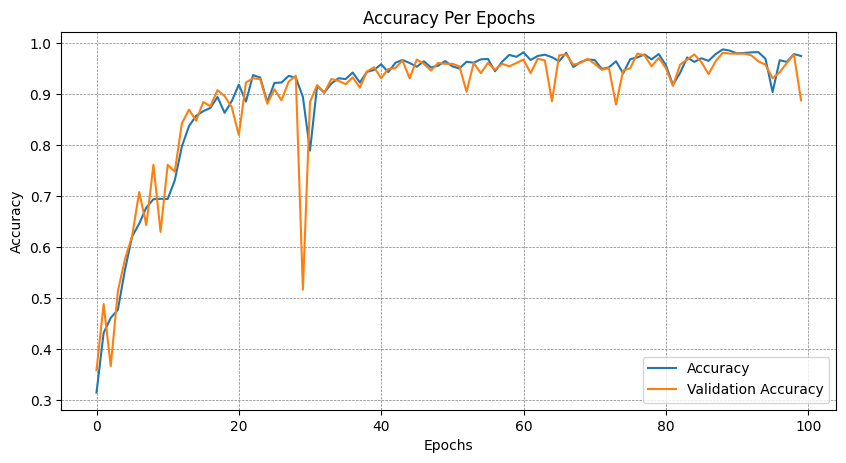

In [49]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_hist_m3[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

In [50]:
# train Accuracy and Loss
train_loss, train_acc = LSTM_model.evaluate(X_train, Y_train, verbose=0)
print("train loss: {0:.6f}, train accuracy: {1:.6f}".format(train_loss, train_acc))

# Val Accuracy and Loss
val_loss, val_acc = LSTM_model.evaluate(X_test, Y_test, verbose=0)
print("val loss: {0:.6f}, val accuracy: {1:.6f}".format(val_loss, val_acc))

train loss: 0.327454, train accuracy: 0.902500
val loss: 0.386866, val accuracy: 0.888333


In [51]:
from sklearn.metrics import confusion_matrix
predict_x=LSTM_model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

y_pred = LSTM_model.predict(X_test)
y_test_class = np.argmax(Y_test, axis=1)
cf_matrix = confusion_matrix(y_test_class, classes_x)
print (cf_matrix)

[[116   0   0   0   7]
 [  2 105   1  24   0]
 [  0   0 124   1   0]
 [  1   0   0 102   0]
 [  0  28   0   3  86]]


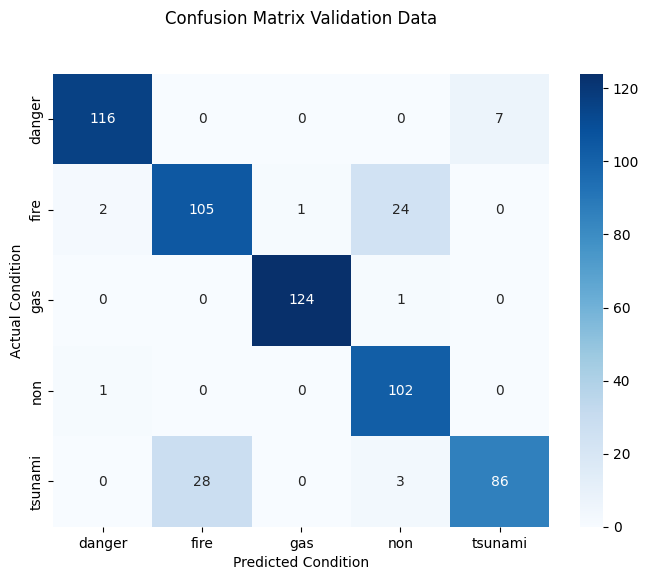

In [52]:
plt.figure(figsize=[8,6], dpi=100)
#confusion matrix prediction of validation data
ax = sns.heatmap(cf_matrix, annot=True, fmt=".0f", cmap='Blues')

ax.set_title('Confusion Matrix Validation Data\n\n');
ax.set_xlabel('Predicted Condition')
ax.set_ylabel('Actual Condition');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['danger','fire', 'gas', 'non','tsunami'])
ax.yaxis.set_ticklabels(['danger','fire', 'gas', 'non','tsunami'])
## Display the visualization of the Confusion Matrix.

plt.show()

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, classes_x))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       123
           1       0.79      0.80      0.79       132
           2       0.99      0.99      0.99       125
           3       0.78      0.99      0.88       103
           4       0.92      0.74      0.82       117

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.90      0.89      0.89       600



## Comparative Analysis

In [54]:
plt.rcParams["figure.figsize"] = (17, 2)
plt.rcParams["figure.dpi"] = 550

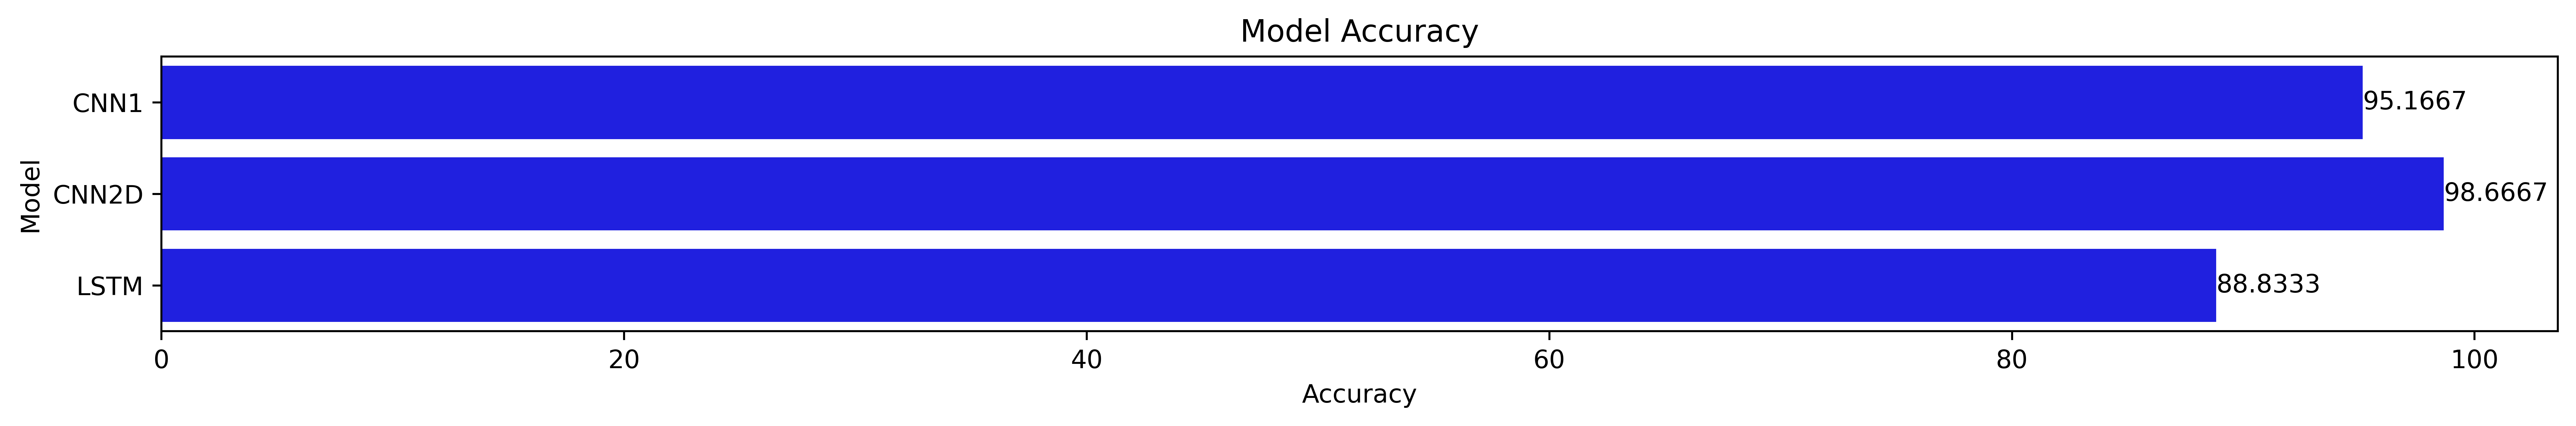

In [55]:
ax = sns.barplot(x="accuracy", y="model", data=log, color="b")
ax.bar_label(ax.containers[0])
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Accuracy")
plt.show()

In [56]:
ax = sns.barplot(x="train_time", y="model", data=log, color="r")
ax.bar_label(ax.containers[0])
plt.xlabel("Training Time")
plt.ylabel("Model")
plt.title("Model Training Time")
plt.show()

ValueError: Could not interpret input 'train_time'

In [58]:
ax = sns.barplot(x="pred_time", y="model", data=log, color="g")
ax.bar_label(ax.containers[0])
plt.xlabel("Prediction Time")
plt.ylabel("Model")
plt.title("Model Prediction Time")
plt.show()

ValueError: Could not interpret input 'pred_time'

In [60]:
log

,model,accuracy,train_time (s),pred_time (s)
0,CNN1,95.166665,54.509,0.248
0,CNN2D,98.666668,120.522,0.250
0,LSTM,88.833332,861.323,1.686
0,LSTM,88.833332,861.323,0.820
